#대스타 

https://zeuskwon-ds.tistory.com/49

### Library

In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

import zipfile
import gdown

### Data Download

In [2]:
google_path = 'https://drive.google.com/uc?id='
file_id = '1bXqNgPQVaDdRHEaFPBsHOq2iUsBglGNK'
output_name = 'train.zip'
gdown.download(google_path+file_id,output_name)

Downloading...
From: https://drive.google.com/uc?id=1bXqNgPQVaDdRHEaFPBsHOq2iUsBglGNK
To: /content/train.zip
100%|██████████| 1.37G/1.37G [00:12<00:00, 105MB/s]


'train.zip'

In [3]:
input_path = './train.zip'
output_path = './data'

In [4]:
zip_data = zipfile.ZipFile(input_path)
zip_data.extractall(output_path)

### image path --> dataframe

In [5]:
dir_ = Path('/content/data/re_train')
filepaths = list(dir_.glob(r'**/*.jpg'))

In [6]:
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df


In [7]:
df = proc_img(filepaths)

#위에서 5개만 본다.
df.head(5)

,Filepath,Label
0,/content/data/re_train/284/train_2444.jpg,284
1,/content/data/re_train/243/train_30946.jpg,243
2,/content/data/re_train/48/train_13142.jpg,48
3,/content/data/re_train/294/train_35219.jpg,294
4,/content/data/re_train/193/train_5423.jpg,193


In [8]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 43232

Number of different labels: 309

Labels: ['284' '243' '48' '294' '193' '253' '226' '164' '146' '254' '128' '14'
 '22' '154' '230' '160' '212' '19' '205' '240' '251' '101' '197' '256'
 '163' '257' '17' '37' '151' '93' '38' '214' '95' '187' '306' '232' '56'
 '274' '149' '21' '55' '126' '30' '76' '168' '236' '188' '130' '204' '69'
 '132' '295' '115' '137' '94' '255' '167' '282' '135' '68' '298' '7' '181'
 '59' '211' '222' '51' '121' '29' '265' '24' '269' '191' '118' '10' '23'
 '108' '42' '206' '3' '120' '267' '186' '90' '180' '208' '147' '266' '113'
 '289' '85' '216' '18' '234' '202' '83' '106' '89' '73' '275' '184' '248'
 '99' '71' '35' '77' '150' '80' '1' '109' '169' '303' '229' '104' '259'
 '84' '60' '27' '8' '13' '47' '102' '45' '278' '97' '138' '155' '283'
 '158' '148' '224' '116' '81' '235' '198' '304' '220' '162' '241' '287'
 '61' '270' '159' '20' '271' '139' '140' '156' '219' '136' '53' '26' '280'
 '79' '190' '272' '119' '49' '225' '273' '260' '92' '305'

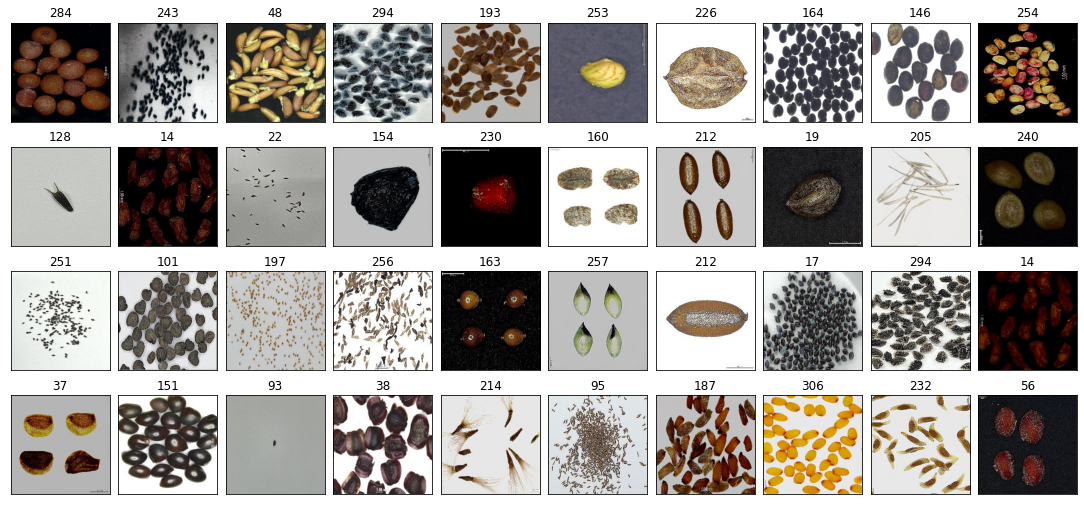

In [9]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

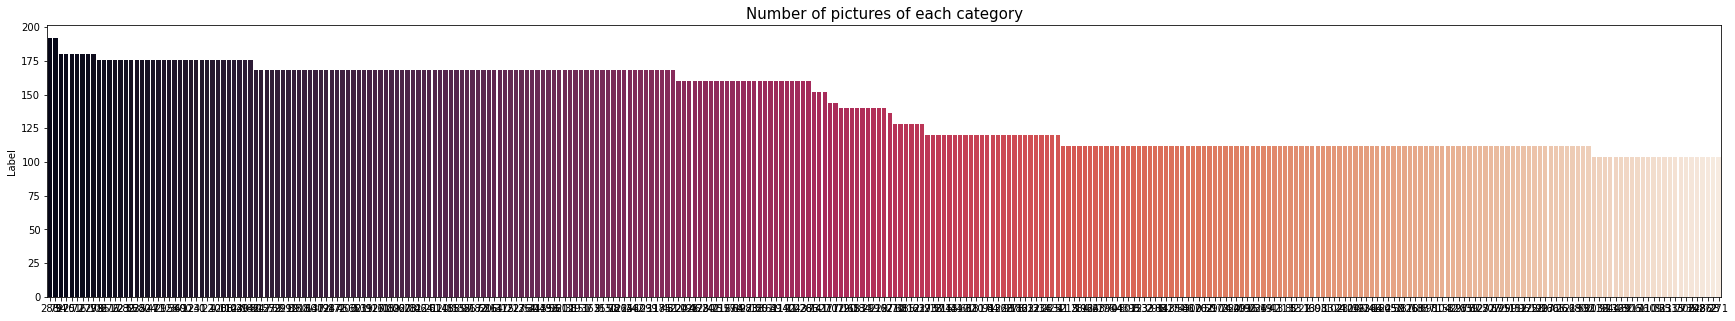

In [10]:
vc = df['Label'].value_counts()
plt.figure(figsize=(30,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

### train, test 분류

In [11]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((38908, 2), (4324, 2))

### Data Processing

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/data/re_train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/data/re_train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 34704 images belonging to 309 classes.
Found 8528 images belonging to 309 classes.


### model

In [13]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256, 256, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=309, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [14]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
1085/1085 [==============================] - 118s 98ms/step - loss: 13.7603 - accuracy: 0.3606 - val_loss: 2.5010 - val_accuracy: 0.5342
Epoch 2/10
1085/1085 [==============================] - 104s 96ms/step - loss: 1.5049 - accuracy: 0.7017 - val_loss: 2.2024 - val_accuracy: 0.5776
Epoch 3/10
1085/1085 [==============================] - 105s 97ms/step - loss: 0.8840 - accuracy: 0.8113 - val_loss: 1.6145 - val_accuracy: 0.6988
Epoch 4/10
1085/1085 [==============================] - 105s 96ms/step - loss: 0.6659 - accuracy: 0.8579 - val_loss: 1.6290 - val_accuracy: 0.7144
Epoch 5/10
1085/1085 [==============================] - 103s 95ms/step - loss: 0.5788 - accuracy: 0.8786 - val_loss: 1.8246 - val_accuracy: 0.7113
Epoch 6/10
1085/1085 [==============================] - 104s 96ms/step - loss: 0.4895 - accuracy: 0.8948 - val_loss: 1.6012 - val_accuracy: 0.7485
Epoch 7/10
1085/1085 [==============================] - 104s 96ms/step - loss: 0.3763 - accuracy: 0.9192 - val_loss: 

### model 성능 높이기

In [15]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(256, 256), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(256, 256),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(256, 256),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

##### 전이 학습 모델 성능 비교

In [16]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [17]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 35018 validated image filenames belonging to 309 classes.
Found 3890 validated image filenames belonging to 309 classes.
Found 4324 validated image filenames belonging to 309 classes.


In [18]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(256, 256, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(309, activation='softmax')(x)
    # 라벨 개수가 309개이기 때문에 Dencs도 309로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [19]:
# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

29097984/29084464 [==============================] - 0s 0us/step


DenseNet121          trained in 154.15 sec
9420800/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 102.75 sec
74850304/74836368 [==============================] - 0s 0us/step
DenseNet201          trained in 238.86 sec
16719872/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 116.84 sec
27033600/27018416 [==============================] - 1s 0us/step
EfficientNetB1       trained in 142.8 sec
87924736/87910968 [==============================] - 1s 0us/step


InceptionV3          trained in 121.08 sec
12697600/12683000 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 102.91 sec
234561536/234545216 [==============================] - 5s 0us/step
ResNet152V2          trained in 372.08 sec
94781440/94765736 [==============================] - 1s 0us/step
ResNet50             trained in 169.55 sec
94683136/94668760 [==============================] - 2s 0us/step
ResNet50V2           trained in 144.78 sec
80150528/80134624 [==============================] - 2s 0us/step
VGG19                trained in 286.78 sec
58900480/58889256 [==============================] - 1s 0us/step
VGG16                trained in 240.38 sec
83697664/83683744 [==============================] - 2s 0us/step
Xception             trained in 216.8 sec


In [20]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

**DenseNet121 has a 78.08% accuracy on the test set**
**MobileNetV2 has a 76.48% accuracy on the test set**
**DenseNet201 has a 81.31% accuracy on the test set**
**EfficientNetB0 has a 0.69% accuracy on the test set**
**EfficientNetB1 has a 0.58% accuracy on the test set**
**InceptionV3 has a 69.77% accuracy on the test set**
**MobileNetV3Large has a 30.11% accuracy on the test set**
**ResNet152V2 has a 80.64% accuracy on the test set**
**ResNet50 has a 24.51% accuracy on the test set**
**ResNet50V2 has a 81.41% accuracy on the test set**
**VGG19 has a 48.50% accuracy on the test set**
**VGG16 has a 50.46% accuracy on the test set**
**Xception has a 73.15% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,ResNet50V2,0.8231,0.8141,144.78
1,DenseNet201,0.8072,0.8131,238.86
2,ResNet152V2,0.7951,0.8064,372.08
3,DenseNet121,0.7753,0.7808,154.15
4,MobileNetV2,0.7730,0.7648,102.75
5,Xception,0.7290,0.7315,216.80
6,InceptionV3,0.6920,0.6977,121.08
7,VGG16,0.5087,0.5046,240.38
8,VGG19,0.4949,0.4850,286.78
9,MobileNetV3Large,0.3015,0.3011,102.91


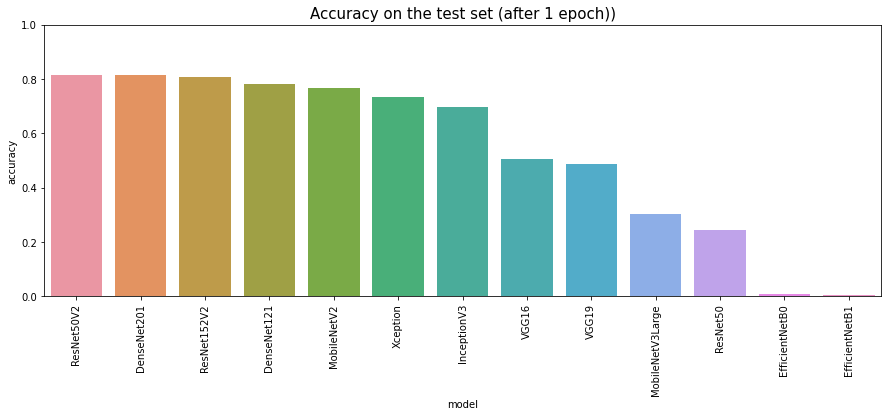

In [21]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

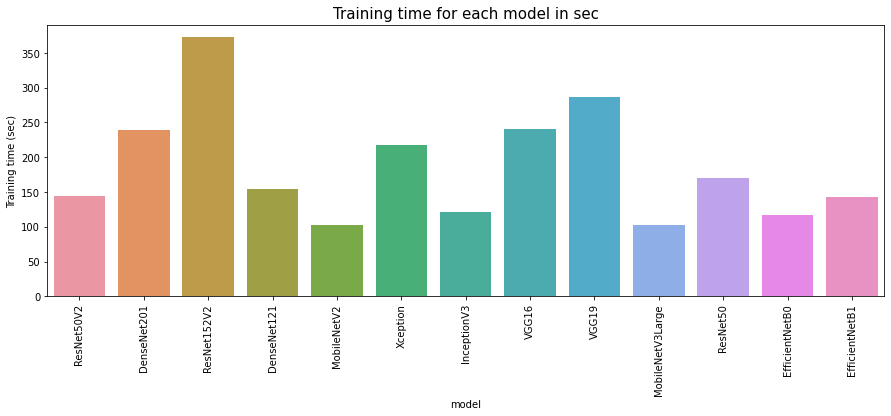

In [22]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

##### DenseNet201

In [23]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 35018 validated image filenames belonging to 309 classes.
Found 3890 validated image filenames belonging to 309 classes.
Found 4324 validated image filenames belonging to 309 classes.
Epoch 1/7
1095/1095 [==============================] - 244s 215ms/step - loss: 1.8728 - accuracy: 0.5930 - val_loss: 0.7483 - val_accuracy: 0.7972
Epoch 2/7
1095/1095 [==============================] - 231s 211ms/step - loss: 0.5108 - accuracy: 0.8596 - val_loss: 0.4386 - val_accuracy: 0.8738
Epoch 3/7
1095/1095 [==============================] - 232s 211ms/step - loss: 0.3169 - accuracy: 0.9081 - val_loss: 0.3335 - val_accuracy: 0.9057
Epoch 4/7
1095/1095 [==============================] - 231s 211ms/step - loss: 0.2221 - accuracy: 0.9338 - val_loss: 0.2717 - val_accuracy: 0.9190
Epoch 5/7
1095/1095 [==============================] - 232s 211ms/step - loss: 0.1764 - accuracy: 0.9459 - val_loss: 0.2528 - val_accuracy: 0.9203
Epoch 6/7
1095/1095 [==============================] - 232s 211ms/step - lo

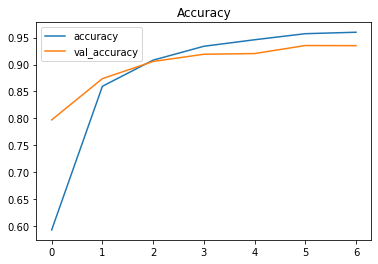

In [24]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

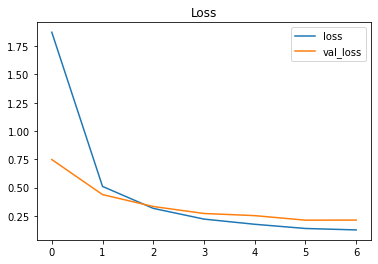

In [25]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 93.46%


##### ResNet50V2

In [27]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=5)

Found 35018 validated image filenames belonging to 309 classes.
Found 3890 validated image filenames belonging to 309 classes.
Found 4324 validated image filenames belonging to 309 classes.
Epoch 1/5
1095/1095 [==============================] - 151s 136ms/step - loss: 1.7838 - accuracy: 0.6083 - val_loss: 0.7018 - val_accuracy: 0.8167
Epoch 2/5
1095/1095 [==============================] - 148s 135ms/step - loss: 0.4957 - accuracy: 0.8628 - val_loss: 0.4716 - val_accuracy: 0.8607
Epoch 3/5
1095/1095 [==============================] - 148s 135ms/step - loss: 0.3018 - accuracy: 0.9108 - val_loss: 0.3479 - val_accuracy: 0.8967
Epoch 4/5
1095/1095 [==============================] - 147s 135ms/step - loss: 0.2209 - accuracy: 0.9343 - val_loss: 0.3566 - val_accuracy: 0.8907
Epoch 5/5
1095/1095 [==============================] - 148s 135ms/step - loss: 0.1695 - accuracy: 0.9480 - val_loss: 0.2864 - val_accuracy: 0.9188


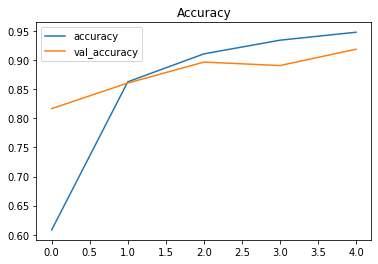

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

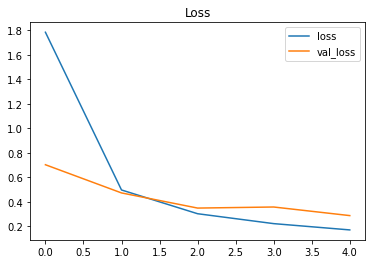

In [29]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

# Accuracy on the test set: 91.07%

In [31]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      0.56      0.67        16
           1       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        15
         100       1.00      1.00      1.00        17
         101       0.62      0.77      0.69        13
         102       1.00      1.00      1.00        10
         103       0.52      0.88      0.65        16
         104       1.00      1.00      1.00        11
         105       0.93      1.00      0.96        13
         106       0.71      0.56      0.63        18
         107       1.00      0.43      0.60         7
         108       0.46      0.93      0.62        14
         109       0.80      0.92      0.86        13
          11       1.00      0.81      0.90        16
         110       0.21      0.56      0.30         9
         111       1.00      0.93      0.97        15
         112       0.79      0.79      0.79        14
         113       1.00    

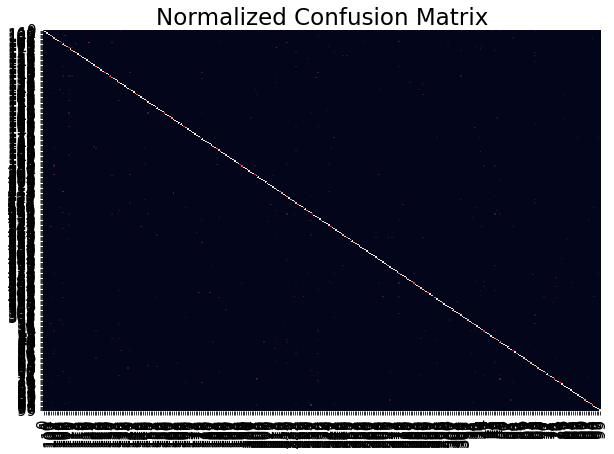

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 예측

In [33]:
import pandas as pd

df = pd.read_csv('/content/data/label.csv', encoding='cp949')

class_dictionary = {}
for i in range(len(df)):
  class_dictionary[df.iloc[i][0]] = df.iloc[i][1]

번호를 입력하세요 : 10


## 예측률 : 99.49%

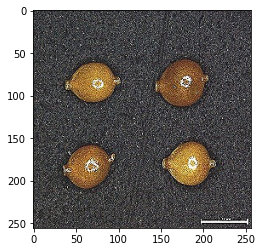

In [34]:
# from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
IMAGE_SIZE    = (256, 256)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

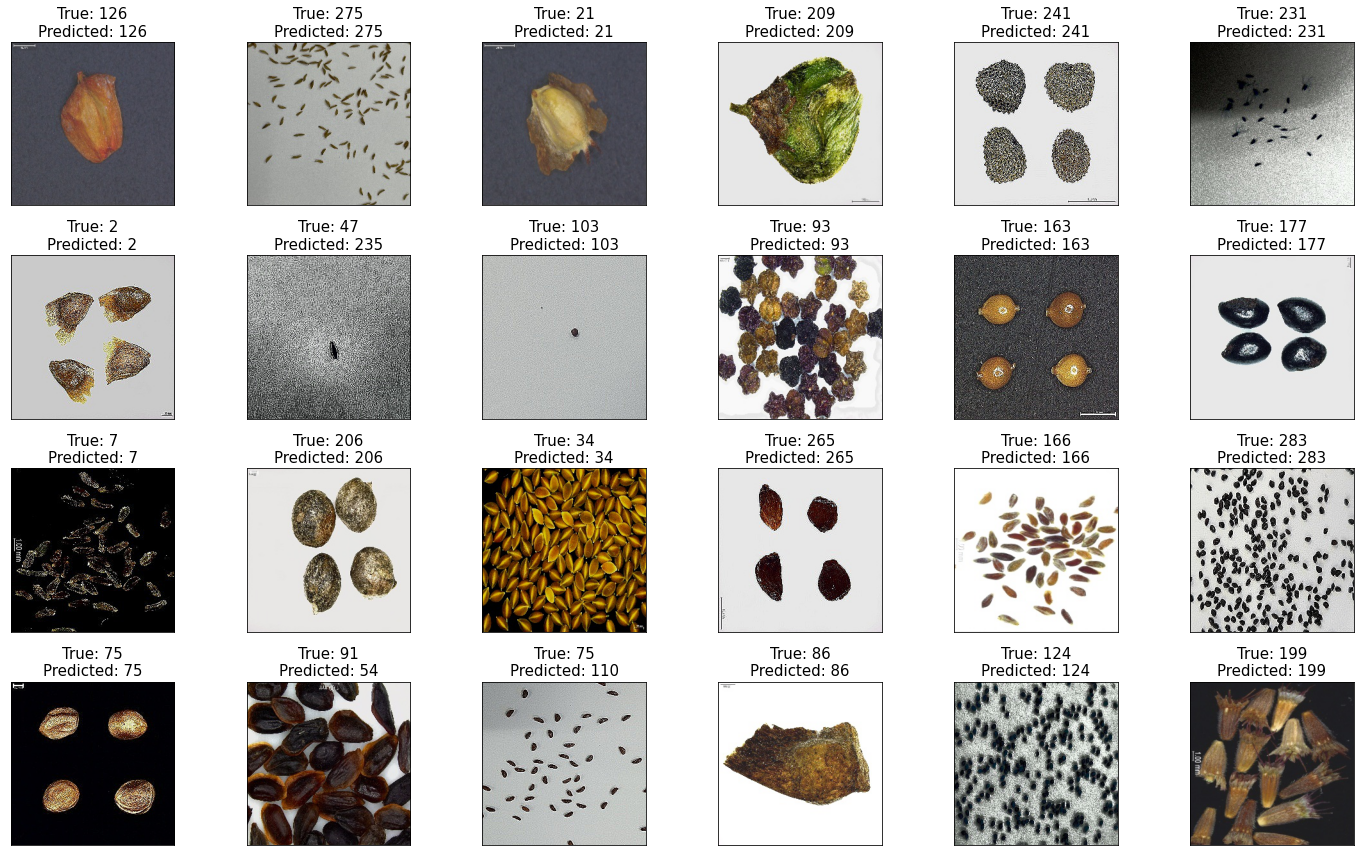

In [35]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()